# Load in Packages

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
from skimage.draw import disk
from scipy.optimize import curve_fit
from scipy import signal
from scipy.fft import fft, fftshift
#from lmfit import Parameters, minimize, report_fit
from obspy.imaging.cm import viridis_white
import cmocean
import xarray as xr
from math import nan

from Loader import DataLoader
from Main import main
from Manager import DataHandler, FigureHandler, PlotHandler, ValueHandler, SliderManager, EventHandler, CheckButtonManager, ClickButtonManager
import mpes
from mpes import cmap_LTL, cmap_LTL2
%load_ext autoreload
%autoreload 2

# Specify Data to Load

In [6]:
# Specify datapath, filename, and [Energy, Delay] offsets to load.
data_path = 'R:\Lawson\Data\metis'
#data_path = '/Users/lawsonlloyd/Desktop/Data/metis'

filename, offsets = 'Scan162_RT_120x120x115x50_binned.h5', [0.8467, -120]

### Load the data and axes information


In [7]:
# Load the Data
data_loader = DataLoader(data_path + '//' + filename, offsets)
I = data_loader.load()

# Truncate and Normalize Data, if desired.
I = I.loc[{"delay":slice(-350,1100)}]
I = I/np.max(I)
I_res = I

# Generate Difference Data (Pos - Neg Delay Times), if desired.
I_diff = I - I.loc[{"delay":slice(-400,-100)}].mean(dim="delay")
I_diff = I_diff/np.max(I_diff)


The data shape is: (120, 120, 115, 50)
"R:\Lawson\Data\metis//Scan162_RT_120x120x115x50_binned.h5" has been loaded! Happy Analysis...


### Plot Momentum Maps at Constant Energy

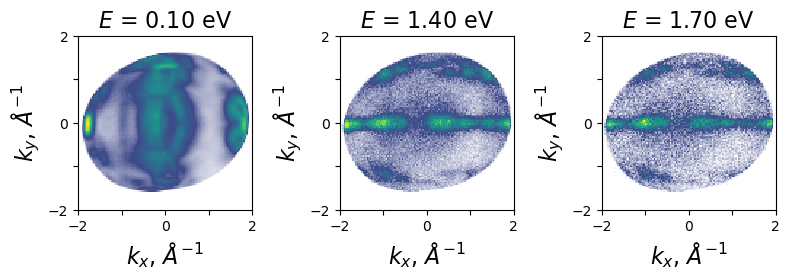

In [8]:
%matplotlib inline
cmap_plot = cmap_LTL

E, E_int = [.1, 1.4, 1.7], 0.1
#delays, delay_int = 500, 1000

fig, ax, im = mpes.plot_momentum_maps(
    I_res, E=E, E_int=0.2, delays=None, delay_int=None,
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 3), colorbar=False, panel_labels = False
)

#mpes.overlay_bz('rectangular', 3.508, 4.763, ax[0], 'black')
#mpes.save_figure(fig, name = f'test', image_format = 'pdf')

### Plot k vs E Cuts

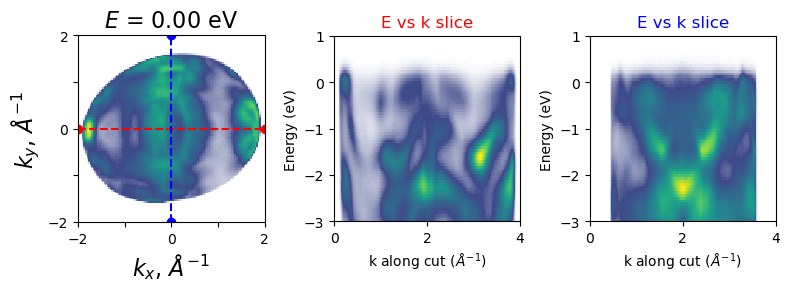

In [48]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(8, 6, forward=False)
axs = axs.flatten()

# Plot momentum map
mpes.plot_momentum_maps(
    I_res, E=0, E_int=0.2, delays=None, delay_int=None,
    fig = fig, ax = axs[0],
    cmap=cmap_plot,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(12, 12)
)

# Plot k - E (arbitrary Cut)
k_start, k_end = (-2, 0), (2, 0)
I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)

axs[0].plot(k_start[0], k_start[1], 'ro')
axs[0].plot(k_end[0], k_end[1], 'ro')
axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'red', linestyle = 'dashed')

axs[1].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
axs[1].set_xlabel("k along cut ($\AA^{-1}$)")
axs[1].set_ylabel("Energy (eV)")
axs[1].set_title("E vs k slice", color = 'red')
axs[1].set_ylim(-3,1)
axs[1].set_aspect(1)

# Plot k - E (arbitrary Cut)
k_start, k_end = (0, -2), (0, 2)
I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)

axs[0].plot(k_start[0], k_start[1], 'bo')
axs[0].plot(k_end[0], k_end[1], 'bo')
axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'blue', linestyle = 'dashed')

axs[2].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
axs[2].set_xlabel("k along cut ($\AA^{-1}$)")
axs[2].set_ylabel("Energy (eV)")
axs[2].set_title("E vs k slice", color = 'blue')
axs[2].set_ylim(-3,1)
axs[2].set_aspect(1)

""" # Plot kx-E frame
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 0.5) # Central (kx, ky) point and k-integration
mpes.plot_kx_frame(
    I_res, ky, ky_int, delays=[500], delay_int=1000,
    E_enhance = 1,
    subtract_neg=True, neg_delays=[-500,-100],
    fig = fig, ax = axs[2],
    cmap = cmap_plot, scale=[0,1], energy_limits=[1,3]
)

# Plot ky-E frame
(kx, ky), (kx_int, ky_int) = (0, 0), (0.5, 0.5) # Central (kx, ky) point and k-integration
mpes.plot_ky_frame(
    I_res, ky, ky_int, delays=[500], delay_int=1000,
    subtract_neg=True, neg_delays=[-500,-100],
    fig = fig, ax = axs[3],
    cmap = cmap_plot, scale=[0,1], energy_limits=[-3,.5]
    ) """

fig.tight_layout()


### Plot (& Fit) Delay Traces


Fit Results for model: biexp
----------------------------------------
A1         =     0.9697 ±  0.1755
tau1       =    33.6737 ±  8.0808
A2         =     0.8464 ±  0.0238
tau2       =  3070.4710 ± 506.3521
----------------------------------------

Fit Results for model: exp_rise_monoexp_decay
----------------------------------------
A          =     1.2642 ±  0.0622
tau_rise   =   111.1579 ± 10.3247
tau_decay  =  1458.1521 ± 169.0777
----------------------------------------


(-0.1, 1.1)

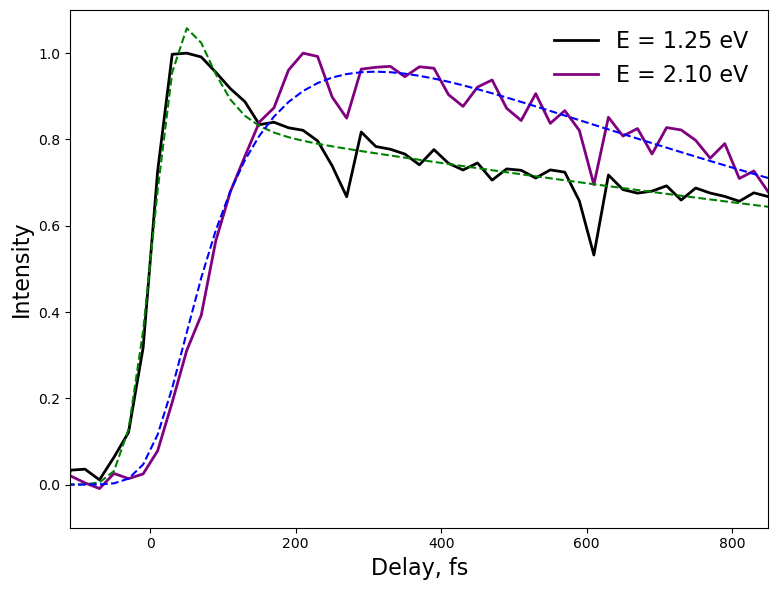

In [13]:
E, E_int = [1.25, 2.1], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
norm_trace = True
subtract_neg = True
neg_delays = [-300, -50]

fig, axs = plt.subplots()
fig.set_size_inches(8, 6, forward=False)
#axs = axs.flatten()

mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace, subtract_neg, neg_delays,
    fig = fig, ax = axs,
    colors = ['black', 'purple'],
    fontsize=16
)

### Do a Fitting: Choose model (input as string, e.g. 'monoexp') and input fit parameters (p0, bounds etc.)
delay_limits = (-200, 900)
delay_axis = I.delay.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

# Curve 1
time_trace = mpes.get_time_trace(I, 1.25, E_int, (kx, ky), (kx_int, ky_int), True, True, neg_delays = (-300, -50))
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

model = 'biexp'
p0 = [1, 100, 1, 1000]
lower_bounds, upper_bounds = (0, 0, 0, 0), (10, 100000, 10, 20000)
popt, pcov, fit_curve_1 = mpes.fit_time_trace(model, delay_axis, time_trace, p0, [lower_bounds, upper_bounds], convolve = True, sigma_IRF = 30)
mpes.print_fit_results(model, popt, pcov)

# Curve 2
time_trace = mpes.get_time_trace(I, 2.1, E_int, (kx, ky), (kx_int, ky_int), True, True, neg_delays = (-300, -50))
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

model = 'exp_rise_monoexp_decay'
p0 = [2, 10, 120] #C, tau_rise, tau_decay1)
lower_bounds, upper_bounds = (0, 0, 0), (10, 2000, 10000)
popt, pcov, fit_curve_2 = mpes.fit_time_trace(model, delay_axis, time_trace, p0, [lower_bounds, upper_bounds], convolve = True, sigma_IRF = 30)
mpes.print_fit_results(model, popt, pcov)

#conv_model = mpes.make_convolved_model(mpes.exp_rise_monoexp_decay, delay_axis, 40)
#init_curve = conv_model(delay_axis, *p0)

# Plot Fits
axs.plot(delay_axis, fit_curve_1, linestyle = 'dashed', color = 'green')
axs.plot(delay_axis, fit_curve_2, linestyle = 'dashed', color = 'blue')
axs.set_ylim(-0.1,1.1)


### Plot Waterfall Trace: k-Integrated Delay Dynamics

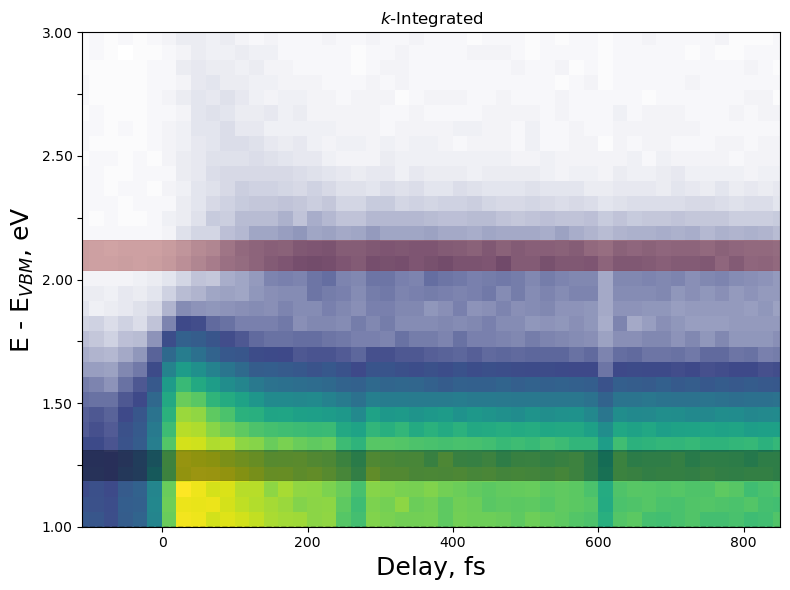

In [20]:
# Plot waterfall
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=False)

E, E_int = [1.25, 2.1], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration

mpes.plot_waterfall(
    I_res, kx, kx_int, ky, ky_int,
    fig = fig, ax = ax,
    cmap=cmap_LTL, scale=[0,1], energy_limits=[1,3]
)

colors = ['black', 'maroon']

for i in np.arange(len(E)):

    rect3 = (Rectangle((-500, E[i]-E_int/2), 2000, E_int , linewidth=.5,\
                         edgecolor=colors[i], facecolor=colors[i], alpha = 0.35))
    ax.add_patch(rect3) #Add rectangle to plot

#ax.axhline(E[0])    
#ax.axhline(E[1])    

### Plot Overview: MM, Delay Traces, k-cut, and Waterfall Panel

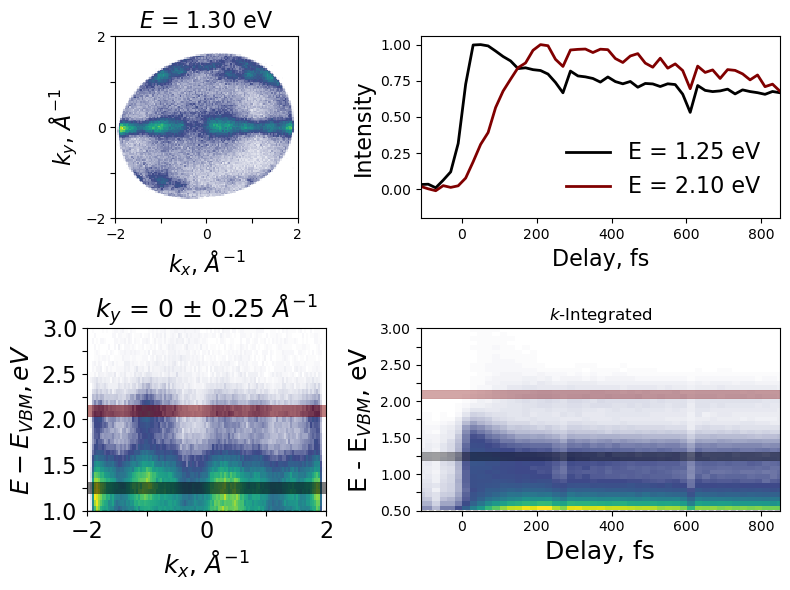

In [21]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1.5], 'height_ratios':[1, 1]})
fig.set_size_inches(8, 6, forward=False)
axs = axs.flatten()

# Plot momentum map
mpes.plot_momentum_maps(
    I_res, E=1.3, E_int=0.2, delays=500, delay_int=1000,
    fig = fig, ax = axs[0],
    cmap=cmap_plot,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(8, 6)
)

# Plot time traces
E, E_int = [1.25, 2.1], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
norm_trace = True
subtract_neg = True
neg_delays = [-300, -50]

mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace, subtract_neg, neg_delays,
    fig = fig, ax = axs[1],
    colors = ['black', 'maroon'],
    fontsize=16
)

# Plot kx-E frame
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 0.5) # Central (kx, ky) point and k-integration
mpes.plot_kx_frame(
    I_res, ky, ky_int, delays=[500], delay_int=1000,
    E_enhance = 1,
    subtract_neg=subtract_neg, neg_delays=neg_delays,
    fig = fig, ax = axs[2],
    cmap = cmap_plot, scale=[0,1], energy_limits=[1,3]
)

# # Plot ky-E frame
# (kx, ky), (kx_int, ky_int) = (0, 0), (0.5, 0.5) # Central (kx, ky) point and k-integration
# mpes.plot_ky_frame(
#     I_res, ky, ky_int, delays=[500], delay_int=1000,
#     subtract_neg=subtract_neg, neg_delays=neg_delays,
#     fig = fig, ax = axs[2],
#     cmap = 'BuPu', scale=[0,1], energy_limits=[1,3]
# )

# Plot waterfall
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
mpes.plot_waterfall(
    I_diff, kx, kx_int, ky, ky_int,
    fig = fig, ax = axs[3],
    cmap=cmap_LTL, scale=[0,1], energy_limits=[.5,3]
)

rect = (Rectangle((kx-kx_int/2, ky-ky_int/2), kx_int, ky_int, linewidth=.5,\
                         edgecolor='fuchsia', facecolor='fuchsia', alpha = 0.3))
if kx_int < 4:
    axs[0].add_patch(rect) #Add rectangle to plot
    
colors = ['black', 'maroon']

for i in np.arange(len(E)):
    rect2 = (Rectangle((kx-kx_int/2, E[i]-E_int/2), kx_int, E_int , linewidth=.5,\
                         edgecolor=colors[i], facecolor=colors[i], alpha = 0.5))
    rect3 = (Rectangle((-500, E[i]-E_int/2), 2000, E_int , linewidth=.5,\
                         edgecolor=colors[i], facecolor=colors[i], alpha = 0.35))
    axs[2].add_patch(rect2) #Add rectangle to plot
    axs[3].add_patch(rect3) #Add rectangle to plot

#mpes.save_figure(fig, name = f'test', image_format = 'pdf')
#test

### Define E = 0 wrt VBM

E_VBM = 0.008 +- 0.003 eV


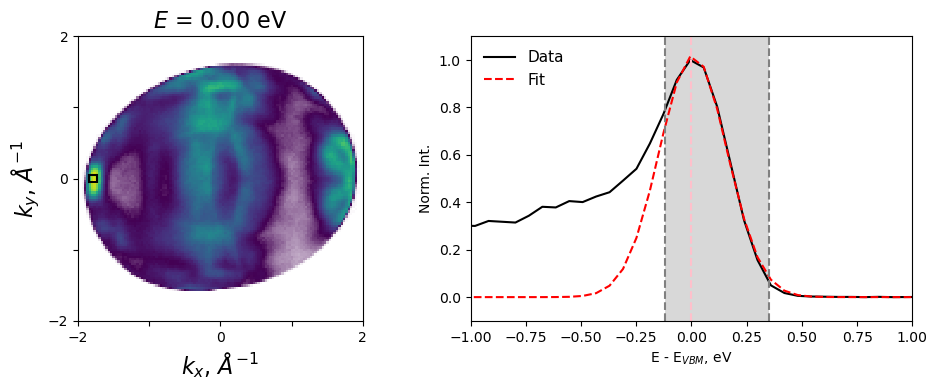

In [22]:
#%% Define E = 0 wrt VBM

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(10, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'vbm'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), k_int = (-2*X, 0), 0.1

delay, delay_int = -200, 200

edc_gamma = mpes.get_edc(I_res, kx, ky, (k_int, k_int), delay, delay_int)
edc_gamma = edc_gamma/np.max(edc_gamma)

mpes.plot_momentum_maps(
    I_res, E=0, E_int=.1, delays=500, delay_int=1000,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
energy_window = [-0.12, 0.35]
p0 = [1, .02, 0.4, 0] # Fitting params initial guess [amp, center, width, offset]

mpes.find_E0(edc_gamma, energy_window, p0, fig, ax)

# cbar_ax = fig.add_axes([.51, 0.275, 0.025, 0.5])
rect = (Rectangle((kx-k_int/2, ky-k_int/2), k_int, k_int, linewidth=1.5,\
                         edgecolor='k', facecolor='None'))

rect1 = (Rectangle((energy_window[0], -.5), (energy_window[1]-energy_window[0]), 2, linewidth=1.5,\
                         edgecolor='none', facecolor='grey', alpha=0.3))

fig.axes[0].add_patch(rect)
fig.axes[1].add_patch(rect1)
ax[1].set_ylim(-0.1,1.1)
ax[1].axvline(energy_window[0], color = 'grey', linestyle = 'dashed')
ax[1].axvline(energy_window[1], color = 'grey', linestyle = 'dashed')
ax[1].axvline(0, color = 'pink', linestyle = 'dashed')


### Define t0 from Signal Rise


t0 = -2.9 +/- 2.7 fs
width = 28.1 +/- 5.3 fs


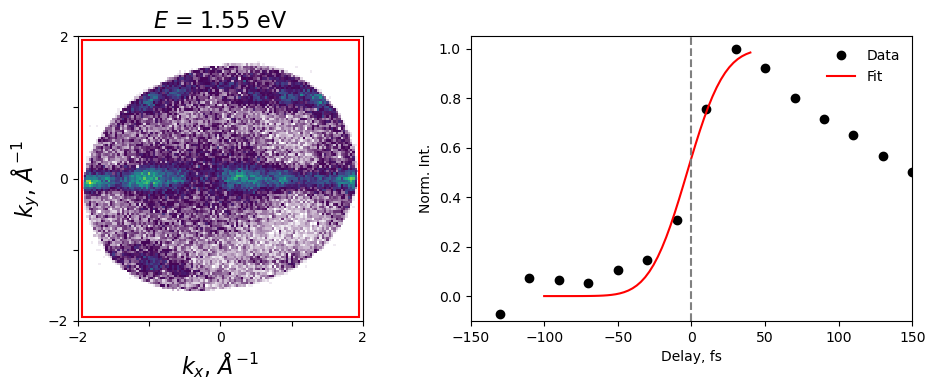

In [26]:
#%% Define t0 from Exciton Rise

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(10, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'define_t0'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), (kx_int, ky_int) = (0, 0), (3.9, 3.9)
#(kx, ky), (kx_int, ky_int) = (0, .7), (1.5, 0.5)
E, E_int = 1.55, 0.1
delay_limits = [-100, 40]

mpes.plot_momentum_maps(
    I_res, E=E, E_int=E_int, delays=200, delay_int=700,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
rect = (Rectangle((kx-kx_int/2, ky-ky_int/2), kx_int, ky_int, linewidth=1.5,\
                         edgecolor='red', facecolor='None'))
fig.axes[0].add_patch(rect)

trace_ex = mpes.get_time_trace(I_res, E, E_int, (kx, ky), (kx_int, ky_int), True, True, neg_delays = (-350, -100))
mpes.find_t0(trace_ex, delay_limits, fig, ax)

if save_figure is True:
    mpes.save_figure(fig, name = f'test', image_format = 'pdf')